In [1]:
from google.colab import drive

from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import shutil
from shutil import move

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_dir =  "gdrive/My Drive/FaceAgeImages"
metadata = pd.read_csv(data_dir + '/age_gender.csv')

In [4]:
# normalization values for pretrained resnet on Imagenet
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

batch_size = 50
validation_batch_size = 10
test_batch_size = 10

# We compute the weights of individual classes and convert them to tensors
#class_weights = estimate_weights_mfb(label)
#class_weights = torch.FloatTensor(class_weights)

transform_train = transforms.Compose([
                    transforms.Resize((128,128)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

transform_test = transforms.Compose([
                    transforms.Resize((128,128)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])

In [5]:
import torch as th
import math

test_size = 0.2
val_size = 0.2
class Sampler(object):
    def __init__(self, data_source):
        pass

    def __iter__(self):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    def __init__(self, class_vector, test_size):
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)
    

dataset = torchvision.datasets.ImageFolder(root= data_dir)
data_label = [s[1] for s in dataset.samples]

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()
# The "pre" is necessary to use array to identify train/ val indices with indices generated by second sampler

train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), test_size)
train_indices, val_indices = ss.gen_sample_array()
indices = {'train': pre_train_indices[train_indices],  # Indices of second sampler are used on pre_train_indices
           'val': pre_train_indices[val_indices],  # Indices of second sampler are used on pre_train_indices
           'test': test_indices
           }

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']
print("Train Data Size:", len(train_indices))
print("Test Data Size:", len(test_indices))
print("Validation Data Size:", len(val_indices))

Train Data Size: 15166
Test Data Size: 4740
Validation Data Size: 3792


In [6]:
SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler

dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=transform_train)

train_samples = SubsetRandomSampler(train_indices)
val_samples = SubsetRandomSampler(val_indices)
test_samples = SubsetRandomSampler(test_indices)

train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False,num_workers=1, sampler= train_samples)
validation_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=val_samples)

dataset = torchvision.datasets.ImageFolder(root= data_dir, transform=transform_test)
test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=test_batch_size, shuffle=False, sampler=test_samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    4,      3,      3,      3,      4,      2,      2,      5,      3,      3,      3,      6,      4,      5,      6,      5,      6,      3,      2,      5,      2,      1,      3,      2,      3,      3,      4,      4,      3,      2,      6,      0,      0,      3,      4,      2,      2,      2,      4,      3,      2,      3,      2,      5,      2,      3,      2,      2,      3,      2, 


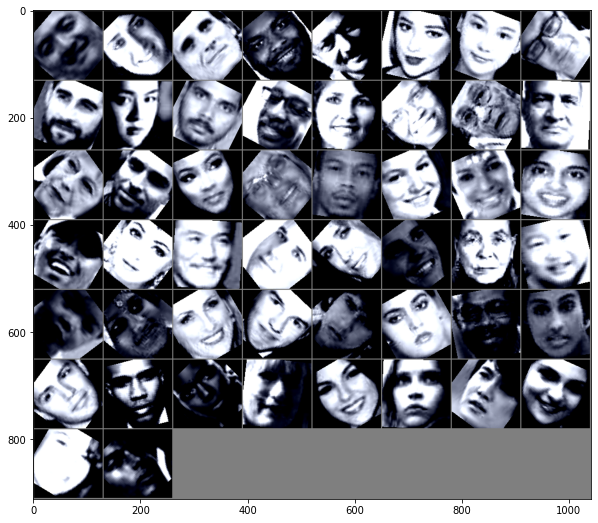

In [7]:
classes = ['0', '1', '2', '3','4', '5', '6']
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5     # denormalize change this
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

In [8]:
from torch import nn

num_classes = len(classes)
net = torchvision.models.resnet18(pretrained = True)

# We replace last layer of resnet to match our number of classes which is 7
net.fc = nn.Linear(512, num_classes)
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [9]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-5)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
from sklearn.metrics import accuracy_score

def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

In [11]:
# number of loops over the dataset
num_epochs = 70
accuracy = []
val_accuracy = []
losses = []
val_losses = []


for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(net, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

Epoch: 1
Loss: 1.701  Accuracy:0.332
Validation Loss: 1.430  Val Accuracy: 0.436
Epoch: 2
Loss: 1.317  Accuracy:0.469
Validation Loss: 1.244  Val Accuracy: 0.491
Epoch: 3
Loss: 1.210  Accuracy:0.502
Validation Loss: 1.184  Val Accuracy: 0.512
Epoch: 4
Loss: 1.158  Accuracy:0.522
Validation Loss: 1.163  Val Accuracy: 0.504
Epoch: 5
Loss: 1.120  Accuracy:0.532
Validation Loss: 1.153  Val Accuracy: 0.515
Epoch: 6
Loss: 1.104  Accuracy:0.547
Validation Loss: 1.142  Val Accuracy: 0.536
Epoch: 7
Loss: 1.083  Accuracy:0.551
Validation Loss: 1.120  Val Accuracy: 0.528
Epoch: 8
Loss: 1.067  Accuracy:0.557
Validation Loss: 1.069  Val Accuracy: 0.549
Epoch: 9
Loss: 1.049  Accuracy:0.568
Validation Loss: 1.083  Val Accuracy: 0.550
Epoch: 10
Loss: 1.035  Accuracy:0.566
Validation Loss: 1.081  Val Accuracy: 0.544
Epoch: 11
Loss: 1.023  Accuracy:0.573
Validation Loss: 1.053  Val Accuracy: 0.558
Epoch: 12
Loss: 1.002  Accuracy:0.576
Validation Loss: 1.052  Val Accuracy: 0.555
Epoch: 13
Loss: 0.993  Ac

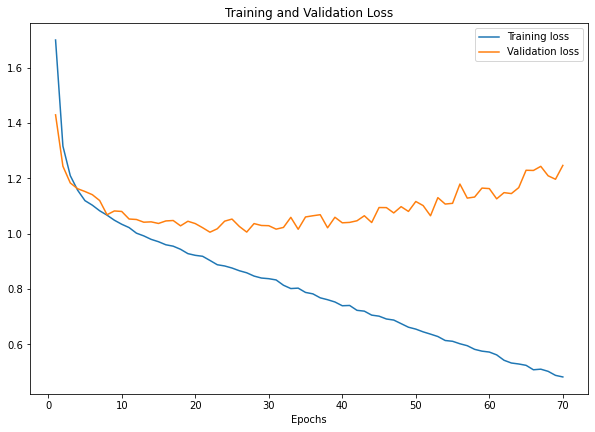

<Figure size 432x288 with 0 Axes>

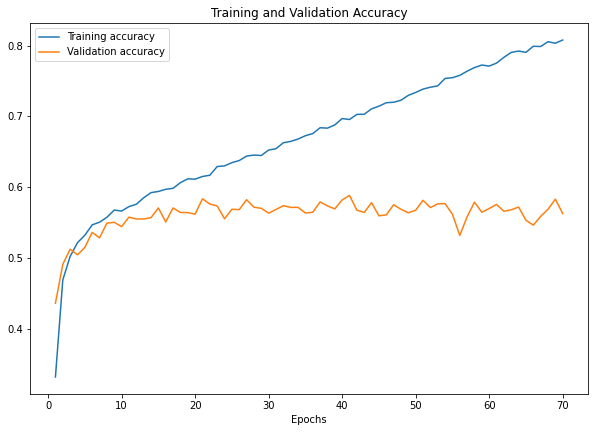

<Figure size 432x288 with 0 Axes>

In [12]:
epoch = range(1, num_epochs+1)
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:      4,       5,       0,       0,       0,       0,       3,       6,       1,       0,  


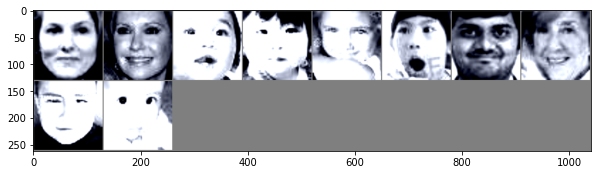

In [13]:
fig = plt.figure(figsize=(10, 15))
dataiter = iter(test_data_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s,  ' % classes[labels[j]] for j in range(len(labels))))

In [21]:
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 55 %


In [22]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
target_names = ['1-7', '8-15', '16-25', '26-35', '36-45', '46-65', '66-116']

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        target_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   1-7 : 91 %
Accuracy of  8-15 : 46 %
Accuracy of 16-25 : 43 %
Accuracy of 26-35 : 69 %
Accuracy of 36-45 : 34 %
Accuracy of 46-65 : 49 %
Accuracy of 66-116 : 64 %


In [23]:
confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
cm = confusion_matrix.numpy()

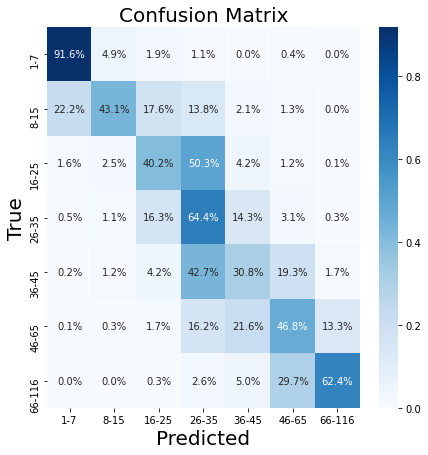

In [24]:
target_names = ['1-7', '8-15', '16-25', '26-35', '36-45', '46-65', '66-116']
fig,ax= plt.subplots(figsize=(7,7))
sns.heatmap(cm / (cm.astype(np.float).sum(axis=1, keepdims=True)), annot=True, fmt='.1%', cmap='Blues')
ax.set_xlabel('Predicted', size=20);
ax.set_ylabel('True', size=20);
ax.set_title('Confusion Matrix', size=20);
ax.xaxis.set_ticklabels(target_names, size=10); \
ax.yaxis.set_ticklabels(target_names, size=10);